The purpose of this notebook is only to generate figures for quantifying the effectiveness of the learning agent described in this project. In particular we would like to demonstrate how effective the agent is at learning the environment over several different seeds. We run 10 freshly initialized agents with different seeds and then plot an envelope of the obtained score after each episode where the lower band of the envelope is the worst score achieved, the upper band is the best score achieved, and the solid line is the median of all of the agents.

We then take a moving average over 100 episodes and generate the same envelope on the smoothed data. Note that this is slightly different from smoothing the median values themselves, but should be close enough and have the same explanatory value.

In [1]:
from unityagents import UnityEnvironment
import numpy as np

# please do not modify the line below
env = UnityEnvironment(file_name="../Banana_Windows_x86_64/Banana.exe")

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [2]:
import random
import torch
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
%matplotlib inline

import double_dqn_agent as DoubleDQN

In [3]:
def dqn(agent,n_episodes=1000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
        
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name] # reset the environment
        state = env_info.vector_observations[0]            # get the current state
        score = 0                                          # initialize the score
        for t in range(max_t):
            action = agent.act(state, eps).astype('int')
            
            env_info = env.step(action)[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished
            
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores.append(score)              # save most recent score
        scores_window.append(score)       # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
    return scores

In [4]:
num_trainings = 10

all_scores = []
for i in range(num_trainings):
    print(f"\nAgent {i}")
    agent = DoubleDQN.Agent(state_size = 37, action_size = 4, seed = i)
    scores = dqn(agent,n_episodes = 800)
    all_scores.append(scores)
    
scores = np.array(all_scores)
np.save('DoubleDqnScores',scores)


Agent 0
Episode 800	Average Score: 15.10
Agent 1
Episode 800	Average Score: 16.01
Agent 2
Episode 800	Average Score: 15.73
Agent 3
Episode 800	Average Score: 15.11
Agent 4
Episode 800	Average Score: 15.71
Agent 5
Episode 800	Average Score: 15.75
Agent 6
Episode 800	Average Score: 16.27
Agent 7
Episode 800	Average Score: 15.16
Agent 8
Episode 800	Average Score: 15.60
Agent 9
Episode 800	Average Score: 15.49

In [7]:
def calculateEnvelope(x):
    return (np.max(x, axis = 0), np.min(x, axis = 0), np.median(x, axis = 0))

def plotEnvelope(scores, solvedScore = 13):
    scores_max, scores_min, scores_median = calculateEnvelope(scores)
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(len(scores[0])), scores_median)
    plt.fill_between(np.arange(len(scores[0])),scores_min,scores_max,alpha = 0.5)
    
    # Add dotted line at "solved" score and vertical line where this crosses the median
    plt.plot([0,scores.shape[1]],[13, 13], linestyle = ':', color = 'k')
    plt.axvline(x = np.argmax(scores_median > solvedScore), color = 'm')
    
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show()

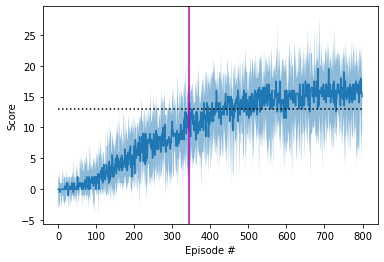

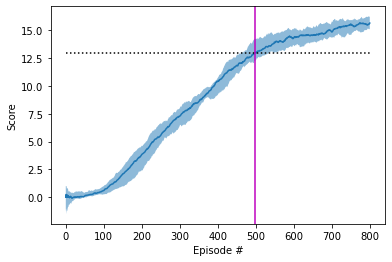

In [8]:
def calculateMovingAverages(values, windowSize = 100):
    sums = np.cumsum(values,axis = 1)
    rampUp = sums[:,0:windowSize] / np.arange(1,windowSize + 1)
    averaged = (sums[:,windowSize:] - sums[:,0:-windowSize]) / windowSize
    return np.concatenate((rampUp,averaged), axis = 1)

scores = np.load('DoubleDqnScores.npy')
averagedScores = calculateMovingAverages(scores, 100)

plotEnvelope(scores)
plotEnvelope(averagedScores)

In [8]:
env.close()